In [1]:
import pandas as pd
import string
import matplotlib.pyplot as plt
import torch
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, AdamW
from sklearn.model_selection import train_test_split
from tqdm.autonotebook import tqdm
from torch.utils.data import random_split
from sklearn.metrics import confusion_matrix
import numpy as np

In [2]:
train = pd.read_csv("../data/train.csv")
# test = pd.read_csv("../data/test.csv")
# train, test = train_test_split(train, test_size=0.2)


In [ ]:
train.head()

,text,aspect,label
3447,so my colleague used one of your templates to ...,template,1
1158,"It’s just me, yet I can’t get notifications un...",get notifications,0
2390,"Application that is used relatively little, we...",desktop application,2
70,no immediate solution to queries,No immediate solution,0
486,this app has the best feature of other apps pl...,links.,2


In [ ]:
data_plt = train['label'].value_counts()

In [ ]:
def preprocess(df):
    df['text'] = df['text'].apply(lambda x : str(x).lower())
    df['label'] = df['label'].apply(lambda x : int(x))
    df['aspect'] = df['aspect'].apply(lambda x : str(x).lower())
    df['text'] = df['text'].apply(lambda x : str(x).translate(str.maketrans('','',string.punctuation))) #removing punctuation
    df['aspect'] = df['aspect'].apply(lambda x : str(x).translate(str.maketrans('','',string.punctuation))) #removing punctuation
    df['text'] = df['text'].apply(lambda x : str(x).translate(str.maketrans('','',string.digits))) #removing integers
    df['aspect'] = df['aspect'].apply(lambda x : str(x).translate(str.maketrans('','',string.digits))) #removing integers
    return df

[1343 1025  832]


<BarContainer object of 3 artists>

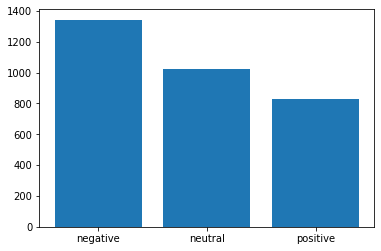

In [ ]:
names = ['negative', 'neutral', 'positive']
# print(dir(data_plt))
print(data_plt.values)
vals = list(data_plt.values)
plt.bar(names,vals)

In [ ]:
print(data_plt)

0    1680
1    1294
2    1026
Name: label, dtype: int64


In [ ]:
def load():
    train_f1 = preprocess(train)
    test_f1 = preprocess(test)
    tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
    datasets = {
        "train": train_f1,
        "test": test_f1,
    }
    for i in datasets:
        data = datasets[i] # Get the dataset
        labels = list(data.label)
        encoded_tokenize = tokenizer(list(data.text),
         list(data.aspect), 
         padding=True, 
         truncation=True, 
         max_length = 512, 
         return_tensors = "pt")
        datasets[i] = torch.utils.data.TensorDataset(
            encoded_tokenize["input_ids"],
            encoded_tokenize["attention_mask"],
            torch.tensor(labels, dtype=torch.long).reshape(-1,1)
        )
    
    return datasets["train"], datasets["test"]


In [ ]:
a,b = load()

In [ ]:
def acc(confusion: np.array) -> float:
    return confusion.trace() / confusion.sum().sum()


def mcc(confusion: np.array) -> float:
    t = confusion.sum(0)
    p = confusion.sum(1)
    c = confusion.trace()
    s = confusion.sum().sum()

    num = c*s - t.dot(p)
    den = np.sqrt(s**2 - p.dot(p))*np.sqrt(s**2 - t.dot(t))

    return num / den

In [ ]:
def train_absa(config: dict):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    num_labels = 3
    numeric_labels = list(range(num_labels))

    model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=num_labels)
    model.train()
    model.to(device)

    optimizer = AdamW(
        model.parameters(),
        lr=config["lr"]
    )

    train_set, test_set = load()

    cutoff = int(0.8 * len(train_set))
    train_subset, val_subset = random_split(train_set, [cutoff, len(train_set) - cutoff])

    train_loader = torch.utils.data.DataLoader(
        train_subset,
        batch_size=int(config["batch_size"]),
        shuffle=True
    )
    val_loader = torch.utils.data.DataLoader(
        val_subset,
        batch_size=int(config["batch_size"]),
        shuffle=True
    )

    # Train
    total = (cutoff // config["batch_size"]) + int(cutoff % config["batch_size"] != 0)

    for epoch in range(config["epochs"]):

        for i, (input_ids, attention_mask, labels) in tqdm(enumerate(train_loader), total=total):
          
            optimizer.zero_grad()

            # print(labels,'labels1')

            output = model(
                input_ids=input_ids.to(device),
                attention_mask=attention_mask.to(device),
                labels=labels.to(device)
            )
            # print(labels,'labels2')
            loss = output["loss"]

            loss.backward()
            optimizer.step()

        # Validation
        running_loss = 0.0
        steps = 0
        confusion = np.zeros([num_labels, num_labels])

        for i, (input_ids, attention_mask, labels) in enumerate(val_loader):

            with torch.no_grad():

                output = model(
                    input_ids=input_ids.to(device),
                    attention_mask=attention_mask.to(device),
                    labels=labels.to(device)
                )
                loss, logits = output["loss"], output["logits"]

                confusion += confusion_matrix(
                    y_true=labels.flatten().cpu(), 
                    y_pred=torch.softmax(logits, -1).argmax(-1).cpu(), 
                    labels=numeric_labels
                )

                running_loss += loss.cpu().numpy()
                steps += 1

        summary = dict(
            loss=(running_loss / steps),
            accuracy=acc(confusion),
            mcc=mcc(confusion)
        )
        print(summary)


    torch.save(model, f"./absa-distil_bert.pt")
    print("Finished training.")

    return model

In [ ]:
config ={
    "epochs": 4,
    "batch_size": 24,
    "lr": 2e-5
}

In [ ]:
model = train_absa(config)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier


{'loss': 0.7288350352534542, 'accuracy': 0.678125, 'mcc': 0.5093228346302457}



{'loss': 0.6657927996582456, 'accuracy': 0.7171875, 'mcc': 0.5631030502937846}



{'loss': 0.6964831252892812, 'accuracy': 0.7265625, 'mcc': 0.5826752175707954}



{'loss': 0.8420388196353559, 'accuracy': 0.7109375, 'mcc': 0.5563670756242387}
Finished training.


In [ ]:
def evaluate(model, ds, config):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    num_labels = 3
    numeric_labels = list(range(num_labels))

    test_loader = torch.utils.data.DataLoader(
        ds,
        batch_size=int(config["batch_size"]),
        shuffle=True
    )
    model.eval()

    test_loss = 0
    test_steps = 0
    confusion = np.zeros([num_labels, num_labels])

    for i, (input_ids, attention_mask, labels) in enumerate(test_loader):

        with torch.no_grad():

            output = model(
                input_ids=input_ids.to(device),
                attention_mask=attention_mask.to(device),
                labels=labels.to(device)
            )
            loss, logits = output["loss"], output["logits"]

            confusion += confusion_matrix(
                y_true=labels.flatten().cpu(), 
                y_pred=torch.softmax(logits, -1).argmax(-1).cpu(), 
                labels=numeric_labels
            )

            test_loss += loss.cpu().numpy()
            test_steps += 1

    print("Test Results:")
    summary = dict(
        model="distilbert",
        loss=(test_loss / test_steps),
        accuracy=acc(confusion),
        mcc=mcc(confusion)
    )
    print(summary)

    return summary, confusion

In [ ]:
model = torch.load('absa-distil_bert.pt')

In [ ]:
_,test = load()

In [ ]:
summary, confusion = evaluate(model, test, config)

Test Results:
{'model': 'distilbert', 'loss': 0.8242011070251465, 'accuracy': 0.715, 'mcc': 0.56469560054435}


In [ ]:
class SentimentAnalyzer:

    def __init__(self, model, model_name, df):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model = model.to(self.device)
        self.tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
        self.aspects = list(df["aspect"])
        self.labels = ["negative","neutral","positive"]

    def __call__(self, text: str) -> dict:

        encoded = self.tokenizer(
            5*[text],
            self.aspects,
            padding=True,
            truncation=True,
            max_length=512,
            return_tensors="pt"
        )

        with torch.no_grad():
            input_ids = encoded["input_ids"].to(self.device)
            attention_mask = encoded["attention_mask"].to(self.device)

            output = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )
            logits = output["logits"]

            predicted = torch.softmax(logits, -1).argmax(-1)
            y_pred = predicted.cpu()

        return {a: self.labels[y_pred[i]] for i, a in enumerate(self.aspects)}

absa = SentimentAnalyzer(model, config["model_id"])